# Overview:  HW3 - Question 4

In this coding question, you'll implement a classifier with logistic regression
$$ F(w) = \frac{1}{N} \sum_{i=1}^N \log( 1 + e^{-\langle w, x_i \rangle y_i} ). $$

For this problem, I would suggest using functions to prepare the dataset, run gradient descent, and return classification error.  By doing this, you only have to write the code one time and just use the functions to return results for part (4c).

# Loading MNIST Data

In this section, you will learn to load MNIST data.  If you do not have tensorflow available on your jupyter notebook, uncomment the next cell, run it, restart the kernel, and comment the next cell once more.

In [1]:
!pip3 install sklearn
!pip3 install scikit-learn
!pip3 install certifi

In [14]:
# import statements
import pandas as pd
import certifi
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from IPython.display import clear_output
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml

In [3]:
# this cell will take a minute to run depending on your internet connection
X, y = fetch_openml('mnist_784', version=1, return_X_y=True) # getting data from online
print('X shape:', X.shape, 'y shape:', y.shape)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


X shape: (70000, 784) y shape: (70000,)


In [4]:
X.to_numpy()[0].reshape((28,28))

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0

In [5]:
# this cell processes some of the data
digits = {j:[] for j in range(10)}
for j in range(len(y)): # takes data assigns it into a dictionary
    digits[int(y[j])].append(X.iloc[j].values.reshape(28,28))
digits = {j:np.stack(digits[j]) for j in range(10)} # stack everything to be one numpy array
for j in range(10):
    print('Shape of data with label', j, ':', digits[j].shape )

Shape of data with label 0 : (6903, 28, 28)
Shape of data with label 1 : (7877, 28, 28)
Shape of data with label 2 : (6990, 28, 28)
Shape of data with label 3 : (7141, 28, 28)
Shape of data with label 4 : (6824, 28, 28)
Shape of data with label 5 : (6313, 28, 28)
Shape of data with label 6 : (6876, 28, 28)
Shape of data with label 7 : (7293, 28, 28)
Shape of data with label 8 : (6825, 28, 28)
Shape of data with label 9 : (6958, 28, 28)


# (4a) Plotting

Display one randomly selected image from your training data for each digit class. Provide the index number for each image.

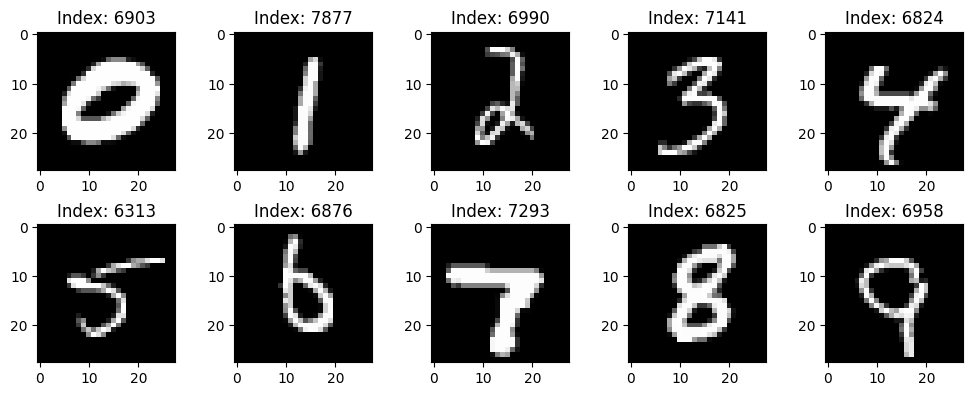

In [6]:
# plot data here (this should have an output)
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col, 2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    curr_digit = digits[i]
    ax.imshow(curr_digit[np.random.randint(curr_digit.shape[0])], cmap='gray')
    ax.set_title('Index: {}'.format(digits[i].shape[0]))
plt.tight_layout()
plt.show()

# (4b) Label data

Select the first 500 examples of 0’s and 1’s for this example, those will form the training data $(x_i , y_i) \in \mathbb{R}^{784} \times \{−1,1\}, i = 1,...,1000$. Assign label $y_i = 1$ for 1s and $y_i = −1$ for 0s.  You can use __np.vectorize__ here.

In [7]:
# create dataset here (essentially just create a numpy array of 1's and -1's for the labels)
# from discussion

def output_data(num1, num2):
    x_train  = np.concatenate([digits[num1][:500].reshape(500,28*28),
                               digits[num2][:500].reshape(500, 28*28)])
    y_train = np.concatenate([np.ones(500), -1*np.ones(500)]).reshape(1000,1)
    x_test = np.concatenate([digits[num1][500:1000].reshape(500,28*28),
                             digits[num2][500:1000].reshape(500,28*28)])
    maxVal = np.max(x_train)
    y_test = y_train
    return x_train/maxVal, y_train, x_test/maxVal, y_test

# (4bi) Running Gradient Descent

Implement and run a Gradient Descent algorithm, with step-size $\mu = 10^{-4}$, to optimize the function above associated with this setup. You should run your algorithm for at least $T = 10,000$ iterations, but if your computer can handle it try $T=100,000$ or until a reasonable stopping criterion is satisfied.  Provide a plot showing the value of $F(w)$ at each iteration. Also, feel free to adjust $\mu$ to be larger / smaller if the plot does not match your expectations.

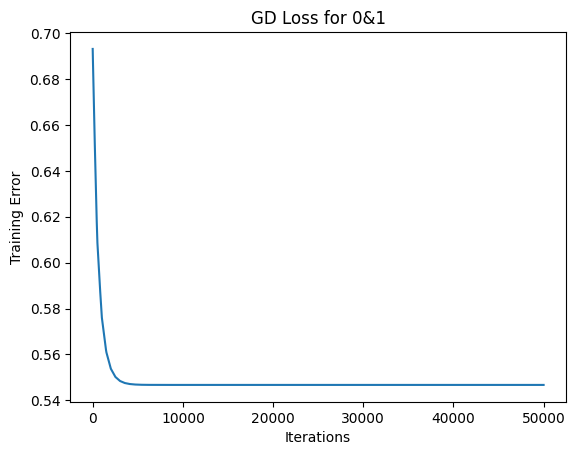

In [8]:
# implement gradient descent here
# from discussion

#w = np.random.normal(size=(784,1))
w = np.zeros((784,1))
#w = np.ones((784,1))

def gradF(w, x_train, y_train):
    expVal = np.exp(-y_train*(x_train @ w))
    grad = (-expVal/(1+expVal))*y_train*x_train
    return grad.transpose().mean(axis=1).reshape((28*28,1))

def F(w, x_train, y_train):
    F = np.log(1+np.exp(-y_train*(x_train @ w))).mean()
    return F

def gradient_descent(w, T=1000, mu=1e-4, num1=0, num2=1, plot=True):
    x_train, y_train, x_test, y_test = output_data(num1, num2)
    F_history = []
    for t in range(T):
        F_history.append(F(w,x_train, y_train))
        w = w-mu*gradF(w, x_train, y_train)
        if(t%500) == 0:
            print('Finished', t, 'iterations...')
            clear_output(wait=True)
            mu = mu/2
            
    if plot:
        plt.plot(range(T), F_history)
        plt.xlabel('Iterations')
        plt.ylabel('Training Error')
        plt.title('GD Loss for '+str(num1)+ '&'+str(num2))

    return w, F_history, x_train, y_train, x_test, y_test

# Call gradient_descent for digits 0 and 1
w, F_history, x_train, y_train, x_test, y_test = gradient_descent(w, T=50000, mu=1e-4, num1=0, num2=1, plot=True)

# (4bii) Discussion about gradient descent

Comment on the resulting plot. In particular, does the shape of $F(w)$ suggest you've successfully converged to a local or global minimum?  Does it appear you chose a good stopping criteria?  Explain whether your
answers to these questions are consistent with the theory we discussed in class (and in the
notes). Be specific i.e., point to a specific theorem (or theorems) and indicate
why it does or does not explain the behavior of the algorithm.  Would the theory dictate a different choice of $\mu$ than the one we used?

Yes because the graph is stabalizing and it is approaching zero, which is what we want in our gradient descent algorithm. This is what a convex function resembles as it is converging to a minimum. In convex optimization, a gradient descent algorithm with a proper step size and suitable initial conditions should converge to the global minimum. Also, our graph shows a good learning rate.

Now, use the $w$ you found from part (a) to classify the first 500 \emph{test} data points associated to
each of the 0 and 1 handwritten digits. Recall that you need to use the function $y = \text{sign}(w^T x)$
to classify. What was the classification error rate associated with the two digits on the test
data (this should be a number between 0 and 1)? What was it on the training data?  Does this relationship make sense?

Yes, because the training error rate and the test error rate are relatively similar which suggests that the model has a good balance between fitting the training data and generalizing to new data.

# (4c) Repeat with 4s and 9s

Repeat parts (b)i. and (b)iii. for digits of 4s and 9s. Comment on the difference between the results and propose a reason as to why the performance did or did not change.

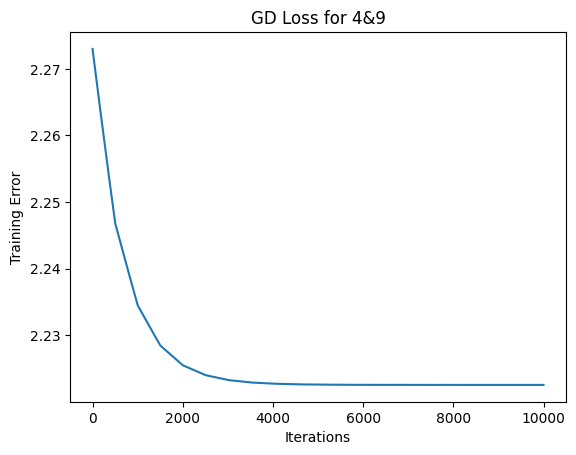

In [10]:
# Repeat here
w = np.random.normal(size=(784,1))
w_star, F_hist, x_train, y_train, x_test, y_test = gradient_descent(w, T=10000, mu=1e-4, num1 =4, num2=9)

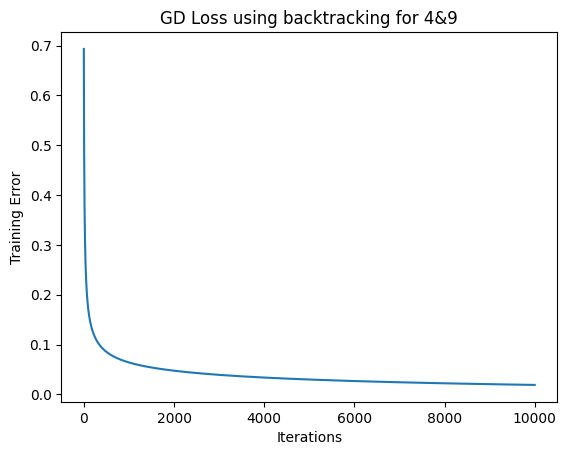

In [11]:
w = np.zeros((784,1))

def gradF(w, x_train, y_train):
    z = np.dot(x_train, w)
    sigmoid = 1/(1+np.exp(-z))
    grad = np.dot(x_train.T,(sigmoid - (y_train==1))) / x_train.shape[0]
    return grad

def F(w, x_train, y_train):
    z = np.dot(x_train, w)
    F = np.log(1+np.exp(-y_train*z))
    F = np.clip(F, a_min = None, a_max = 500)
    return np.mean(F)

def backtrack(F, w, x_train, y_train, grad):
    gamma = 0.5
    beta = 0.8
    mu = 0.1
    while F(w - mu  * grad, x_train, y_train) > F(w, x_train, y_train) - mu * gamma * np.linalg.norm(grad)**2:
        mu = beta * mu
    return mu
    
def gradient_descent(w, T=10, mu=1e-2, num1=4, num2=9, plot=True):
    x_train, y_train, x_test, y_test = output_data(num1, num2)
    F_history = []
    for t in range(T):
        F_history.append(F(w,x_train, y_train))
        gradient = gradF(w,x_train, y_train)
        mu1 = backtrack(F, w, x_train, y_train, gradient)
        w = w-mu1*gradient
        
        if(t%500) == 0:
            print('Finished', t, 'iterations...')
            clear_output(wait=True)
         
    if plot:
        plt.plot(range(T), F_history)
        plt.xlabel('Iterations')
        plt.ylabel('Training Error')
        plt.title('GD Loss using backtracking for '+str(num1)+ '&'+str(num2))

    return w, F_history, x_train, y_train, x_test, y_test

# Call gradient_descent for digits 4 and 9
Tmax = 10000
w_star, F_hist, x_train, y_train, x_test, y_test = gradient_descent(w, T=Tmax, mu=1e-4, num1=4, num2=9, plot=True)

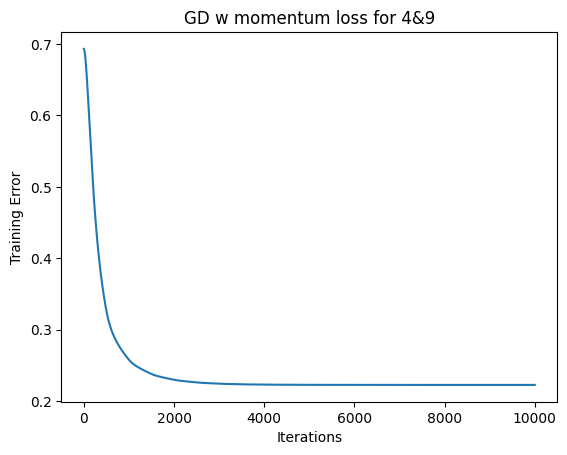

In [23]:
# Gradient Descent with momentum

w = np.zeros((784,1))

def gradF(w, x_train, y_train):
    expected_value = np.exp(-y_train*(x_train @ w))
    gradient = (-expected_value/(1+expected_value))*y_train*x_train
    return gradient.transpose().mean(axis=1).reshape((28*28,1))

def F(w, x_train, y_train):
    F = np.log(1+np.exp(-y_train*(x_train @ w))).mean()
    return F

def gradient_descent(w, T=1000, mu=1e-4, num1=0, num2=1, plot=True):
    x_train, y_train, x_test, y_test = output_data(num1,num2)
    F_history = []
    diff = np.zeros_like(w)
    beta = 0.99

    for t in range(T):
        F_history.append(F(w,x_train,y_train))
        grad = gradF(w, x_train, y_train)
        diff = beta * diff - mu * grad
        w = w + diff
        
        if (t%500) == 0:
            print(t, 'iterations...')
            clear_output(wait=True)
            mu = mu/2

    if plot:
        plt.plot(range(T), F_history)
        plt.xlabel('Iterations')
        plt.ylabel('Training Error')
        plt.title('GD w momentum loss for '+str(num1)+'&'+str(num2))
    
    return w, F_history, x_train, y_train, x_test, y_test

Tmax = 10000
w_star, F_hist, x_train, y_train, x_test, y_test = gradient_descent(w, T=Tmax, mu=1e-4, num1=4, num2=9, plot=True)

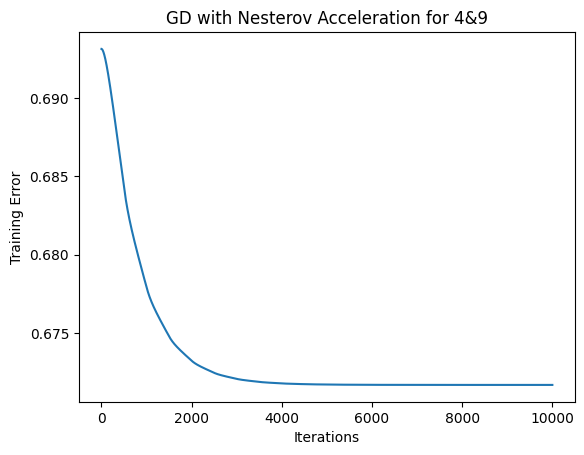

In [24]:
# Gradient Descent with Nesterov Acc

w = np.zeros((784,1))

def gradF(w, x_train, y_train):
    expected_value = np.exp(-y_train*(x_train @ w))
    gradient = (-expected_value/(1+expected_value))*y_train*x_train
    return gradient.transpose().mean(axis=1).reshape((28*28,1))

def F(w, x_train, y_train):
    F = np.log(1+np.exp(-y_train*(x_train @ w))).mean()
    return F

def gradient_descent(w, T=1000, mu=1e-4, num1=0, num2=1, plot=True):
    x_train, y_train, x_test, y_test = output_data(num1,num2)
    F_history = []
    diff = np.zeros_like(w)
    beta = 0.99

    for t in range(T):
        F_history.append(F(w,x_train,y_train))
        look_ahead_position = w + beta * diff
        look_ahead_gradient = gradF(look_ahead_position, x_train, y_train)
        diff = beta * diff - mu * look_ahead_gradient
        w = w + diff
        
        if (t%500) == 0:
            print(t, 'iterations...')
            clear_output(wait=True)
            mu = mu/2

    if plot:
        plt.plot(range(T), F_history)
        plt.xlabel('Iterations')
        plt.ylabel('Training Error')
        plt.title('GD with Nesterov Acceleration for '+str(num1)+'&'+str(num2))
    
    return w, F_history, x_train, y_train, x_test, y_test

Tmax = 10000
w_star, F_hist, x_train, y_train, x_test, y_test = gradient_descent(w, T=Tmax, mu=1e-6, num1=4, num2=9, plot=True)